In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch.optim as optim


from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
batch_size = 128
num_classes = 10
learning_rate = 0.001
num_epochs = 25

In [5]:
# Загружаем датасет, испольуем transforms.compose метод чтобы привести в нужный формат изображения (изменяем размер изображений, преобразуем их в тензоры и нормализуем их), сохраняем в all_transforms
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

# создаем training dataset и testing dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# посмотрим на то, с чем мы работаем
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

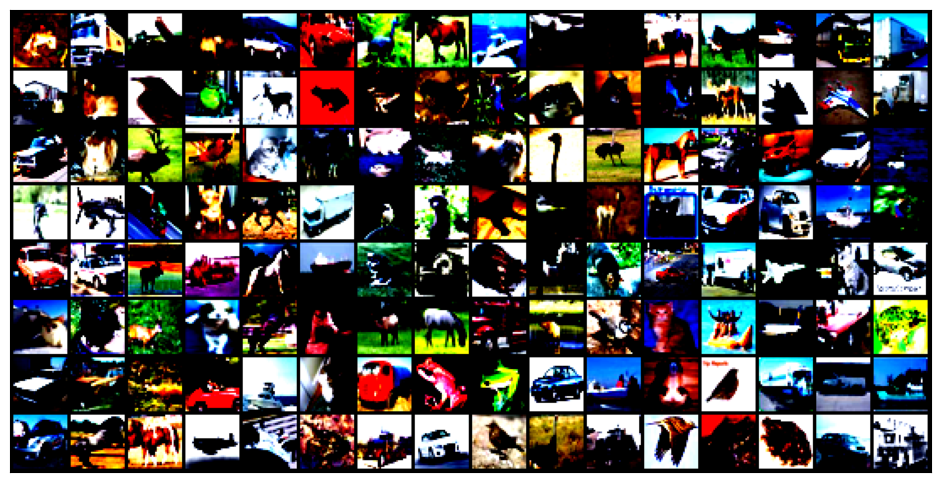

In [7]:
show_batch(train_loader)

In [8]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) # размер ядра начинаем с 3 каналов, т.к. изображения RGB
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU() # функция активации
        self.fc2 = nn.Linear(128, num_classes)

  # определяем forward метод в нашем классе, целью которого является определить порядок, в котором входные данные проходят через наши слои
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

In [9]:
# устанавливаем гиперпараметры:

model = ConvNeuralNet(num_classes) # инициализация нашей модели количеством классов

# перекрестная энтропия в качестве функции потерь
criterion = nn.CrossEntropyLoss()

# стохастический градиентный спуск в качестве оптимизатора
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
if torch.cuda.is_available():
    model.cuda()

In [11]:
device_cpu = torch.device("cpu")

# Обучение модели

In [12]:
def train_model(model, train_loader):
    model.train()
    loss_arr = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())

        return np.mean(loss_arr)


def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.to(device_cpu).numpy())
            all_labels.extend(labels.to(device_cpu).numpy())

    return all_preds, all_labels

In [13]:
for epoch in range(num_epochs):
    loss = train_model(model, train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}')
    # Получение предсказаний и меток
    predictions, labels = evaluate_model(model, test_loader)


Epoch [1/25], Loss: 2.309955596923828
Epoch [2/25], Loss: 2.2288167476654053
Epoch [3/25], Loss: 2.0990262031555176
Epoch [4/25], Loss: 1.9607094526290894
Epoch [5/25], Loss: 1.800191879272461
Epoch [6/25], Loss: 1.6166017055511475
Epoch [7/25], Loss: 1.4409570693969727
Epoch [8/25], Loss: 1.2462230920791626
Epoch [9/25], Loss: 1.0490705966949463
Epoch [10/25], Loss: 0.7959321737289429
Epoch [11/25], Loss: 0.6038621068000793
Epoch [12/25], Loss: 0.4115694761276245
Epoch [13/25], Loss: 0.24527883529663086
Epoch [14/25], Loss: 0.14831991493701935
Epoch [15/25], Loss: 0.05943983420729637
Epoch [16/25], Loss: 0.02586314268410206
Epoch [17/25], Loss: 0.012302186340093613
Epoch [18/25], Loss: 0.007315334863960743
Epoch [19/25], Loss: 0.004341397434473038
Epoch [20/25], Loss: 0.002403822261840105
Epoch [21/25], Loss: 0.0008023390546441078
Epoch [22/25], Loss: 0.0006454103859141469
Epoch [23/25], Loss: 0.00036809532321058214
Epoch [24/25], Loss: 0.00020739977480843663
Epoch [25/25], Loss: 0.00

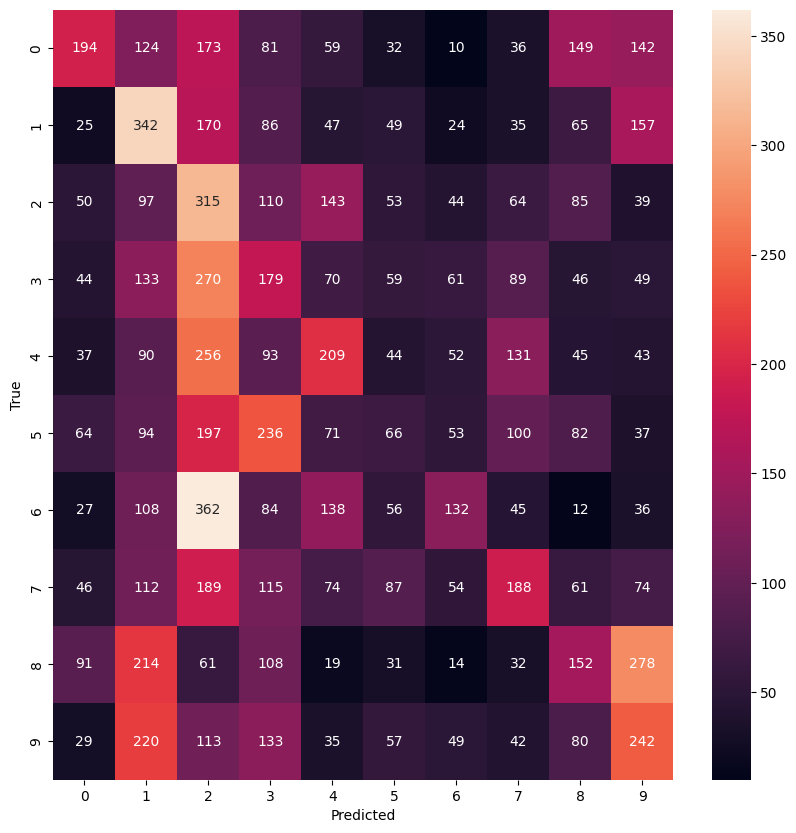

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Построение матрицы ошибок
conf_mat = confusion_matrix(np.array(labels), np.array(predictions))
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()